<a href="https://colab.research.google.com/github/ManGuo1130/Synergistic-effect-evaluation/blob/main/R_GCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
pip install torch torch-geometric pandas scikit-learn

# 数据准备

##处理节点数据

In [4]:
import pandas as pd
import torch
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.nn import RGCNConv
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# 加载节点特征
node_features = pd.read_csv("/content/node_features.csv")
weights_all = pd.read_csv("/content/weights_all.csv")

# 查看数据结构
print(node_features.head())
print(weights_all.head())

   Unnamed: 0   地市        lat         lon       协同度  常住人口  城市建设用地占市区.面积比重  \
0           1  安庆市  30.576049  116.486728  0.549207   417           15.68   
1           2  常州市  31.625341  119.637182  0.784272   528            9.62   
2           3  池州市  30.284429  117.365321  0.660851   134            1.61   
3           4  滁州市  32.544120  118.102548  0.739916   399            6.55   
4           5  杭州市  29.900238  119.469934  0.729286  1197            7.38   

   地区生产总值  人均地区生产总值  第二产业占地区生产总值的比重  第三产业占地区生产总值的比重  工业企业数  专利授权数  绿化覆盖率  \
0    2468     58684           43.23           47.04   1644   5479  39.49   
1    7805    147939           46.33           51.57   5065  41321  43.30   
2     869     64843           44.07           45.80    539   2374  46.13   
3    3032     76087           48.75           42.28   1870   8654  42.30   
4   16106    136617           29.93           68.04   5992  92399  43.36   

   OBJECTID  
0         1  
1         2  
2         3  
3         4  
4         

In [5]:
# 编码节点ID为整数索引
le = LabelEncoder()
node_features['ID_encoded'] = le.fit_transform(node_features['OBJECTID'])

# 创建ID到索引的映射
id_to_index = {id_: idx for idx, id_ in enumerate(node_features['OBJECTID'])}

In [6]:
print(id_to_index)

{1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 12: 11, 13: 12, 14: 13, 15: 14, 16: 15, 17: 16, 18: 17, 19: 18, 20: 19, 21: 20, 22: 21, 23: 22, 24: 23, 25: 24, 26: 25, 27: 26}


In [7]:
# 准备节点特征矩阵
feature_columns = [
    '常住人口', '城市建设用地占市区.面积比重', '地区生产总值',
    '人均地区生产总值', '第二产业占地区生产总值的比重',
    '第三产业占地区生产总值的比重', '工业企业数', '专利授权数',
    '绿化覆盖率'
]

In [8]:
X = node_features[feature_columns].values
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = torch.tensor(X, dtype=torch.float)

In [9]:
print(X)

tensor([[-0.4836,  0.5847, -0.6946, -1.5759, -0.0449, -0.6489, -0.8534, -0.9024,
         -1.5415],
        [-0.2507, -0.2169, -0.0059,  1.1647,  0.4802, -0.0193,  0.3622,  0.0792,
          0.1763],
        [-1.0775, -1.2764, -0.9010, -1.3868,  0.0974, -0.8213, -1.2461, -0.9874,
          1.4523],
        [-0.5214, -0.6230, -0.6219, -1.0415,  0.8901, -1.3106, -0.7731, -0.8154,
         -0.2745],
        [ 1.1533, -0.5132,  1.0653,  0.8171, -2.2975,  2.2701,  0.6916,  1.4780,
          0.2034],
        [ 0.6077,  3.0939,  0.2833, -0.0485, -1.3304,  1.2999, -0.6736,  0.0719,
         -0.4143],
        [-0.6515, -0.4325, -0.6001, -0.4430,  1.0357, -0.7907, -0.0902, -0.5674,
          1.5425],
        [-0.2234,  0.3069, -0.3021, -0.2293,  1.4270, -0.8171,  0.8238, -0.0949,
         -0.8967],
        [ 0.1229, -0.7923, -0.4061, -1.3105, -0.8358,  0.8884,  0.2073,  0.1100,
         -0.6172],
        [-0.9054,  0.2064, -0.7309, -0.2762,  0.7343, -0.5641, -1.0347, -0.8380,
          1.5199],


In [10]:
# 准备目标变量（协同度）
y = torch.tensor(node_features['协同度'].values, dtype=torch.float).unsqueeze(1)

print(y)

tensor([[0.5492],
        [0.7843],
        [0.6609],
        [0.7399],
        [0.7293],
        [0.6852],
        [0.7373],
        [0.7180],
        [0.7326],
        [0.7303],
        [0.8068],
        [0.7315],
        [0.7429],
        [0.8088],
        [0.7640],
        [0.7647],
        [0.7240],
        [0.7559],
        [0.7059],
        [0.6741],
        [0.7913],
        [0.7221],
        [0.7767],
        [0.7872],
        [0.7936],
        [0.7640],
        [0.8117]])


## 构建图数据结果

In [16]:
# 映射ID到索引
weights_all['from_idx'] = weights_all['from'].map(id_to_index)
weights_all['to_idx'] = weights_all['to'].map(id_to_index)

In [17]:
# 处理关系类型
relation_le = LabelEncoder()
weights_all['relation_encoded'] = relation_le.fit_transform(weights_all['relation'])

In [18]:
# 准备边索引和边类型
edge_index = torch.tensor(weights_all[['from_idx', 'to_idx']].values, dtype=torch.long).t().contiguous()
edge_type = torch.tensor(weights_all['relation_encoded'].values, dtype=torch.long)

In [19]:
# 准备边权重
edge_weight = torch.tensor(weights_all['weights'].values, dtype=torch.float)

In [20]:
# 创建图数据对象
data = Data(x=X, edge_index=edge_index, edge_type=edge_type, edge_attr=edge_weight, y=y)

print(data)

Data(x=[27, 9], edge_index=[2, 4509], edge_attr=[4509], y=[27, 1], edge_type=[4509])


# 定义R-GCN模型

In [21]:
import torch.nn.functional as F
from torch_geometric.nn import RGCNConv

In [22]:
class RGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_relations):
        super(RGCN, self).__init__()
        self.conv1 = RGCNConv(in_channels, hidden_channels, num_relations)
        self.conv2 = RGCNConv(hidden_channels, out_channels, num_relations)

    def forward(self, data):
        x, edge_index, edge_type = data.x, data.edge_index, data.edge_type
        x = self.conv1(x, edge_index, edge_type)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_type)
        return x

In [23]:
# 模型参数
in_channels = X.shape[1]
hidden_channels = 16
out_channels = 1  # 预测协同度
num_relations = len(relation_le.classes_)

# 实例化模型
model = RGCN(in_channels, hidden_channels, out_channels, num_relations)

in_channels = X.shape[1]

确定输入特征的维度。
X 是之前准备好的节点特征张量，形状为 [num_nodes, num_features]。
X.shape[1] 获取特征的维度，即num_features，作为in_channels。
hidden_channels = 16

设置隐藏层的特征维度为16。
这是一个经验性选择，可以根据数据和模型表现进行调整。
out_channels = 1 # 预测协同度

设置输出层的特征维度为1，用于回归任务中预测每个节点的协同度。
num_relations = len(relation_le.classes_)

确定关系类型的数量。
relation_le 是之前定义并拟合的LabelEncoder对象，用于编码边的关系类型。
relation_le.classes_ 返回所有的关系类型，每种关系类型对应一个唯一的类别。
len(relation_le.classes_) 计算关系类型的总数，作为RGCNConv层中num_relations的参数。
model = RGCN(in_channels, hidden_channels, out_channels, num_relations)

使用之前定义的RGCN类实例化一个R-GCN模型对象。
参数解释：
in_channels: 输入特征维度，从节点特征矩阵X中获取。
hidden_channels: 隐藏层的特征维度，设置为16。
out_channels: 输出特征维度，设置为1，用于回归任务。
num_relations: 关系类型的数量，确保模型能区分不同类型的边。

In [24]:
# 定义损失函数和优化器
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 训练模型

## 数据集划分

In [25]:
# 设置随机种子以确保可重复性
torch.manual_seed(42)
np.random.seed(42)

# 获取节点数量
num_nodes = data.num_nodes

# 定义划分比例
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

In [26]:
# 确认比例总和为1
assert train_ratio + val_ratio + test_ratio == 1.0, "划分比例之和必须为1.0"

In [27]:
train_ratio + val_ratio + test_ratio

1.0

In [28]:
# 生成随机索引
indices = np.random.permutation(num_nodes)
train_size = int(train_ratio * num_nodes)
val_size = int(val_ratio * num_nodes)

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

# 创建掩码
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[train_indices] = True
val_mask[val_indices] = True
test_mask[test_indices] = True

# 将掩码添加到数据对象中
data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

print(f"训练集节点数: {train_mask.sum().item()}")
print(f"验证集节点数: {val_mask.sum().item()}")
print(f"测试集节点数: {test_mask.sum().item()}")

训练集节点数: 18
验证集节点数: 4
测试集节点数: 5


In [29]:
def train(model, data, optimizer, criterion, epochs=100):
    best_val_loss = float('inf')
    best_model_state = None

    for epoch in range(1, epochs + 1):
        model.train()
        optimizer.zero_grad()

        # 前向传播
        out = model(data)

        # 仅计算训练集的损失
        loss = criterion(out[data.train_mask], data.y[data.train_mask])

        # 反向传播
        loss.backward()
        optimizer.step()

        # 计算验证集损失
        model.eval()
        with torch.no_grad():
            val_out = model(data)
            val_loss = criterion(val_out[data.val_mask], data.y[data.val_mask])

        if epoch % 10 == 0 or epoch == 1:
            print(f'Epoch {epoch}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

        # 保存最佳模型
        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            best_model_state = model.state_dict().copy()
            torch.save(best_model_state, 'best_rgcn_model.pth')
            print(f'最佳模型参数已保存 (Val Loss: {best_val_loss:.4f})')

    print("训练完成。")

In [30]:
train(model, data, optimizer, criterion, epochs=500)

Epoch 1, Train Loss: 11.8320, Val Loss: 7.4189
最佳模型参数已保存 (Val Loss: 7.4189)
最佳模型参数已保存 (Val Loss: 3.2789)
最佳模型参数已保存 (Val Loss: 1.1806)
最佳模型参数已保存 (Val Loss: 0.4873)
Epoch 10, Train Loss: 1.1423, Val Loss: 0.5812
最佳模型参数已保存 (Val Loss: 0.3891)
最佳模型参数已保存 (Val Loss: 0.3007)
Epoch 20, Train Loss: 0.2859, Val Loss: 0.5700
最佳模型参数已保存 (Val Loss: 0.2761)
最佳模型参数已保存 (Val Loss: 0.2505)
最佳模型参数已保存 (Val Loss: 0.2449)
Epoch 30, Train Loss: 0.0875, Val Loss: 0.3090
Epoch 40, Train Loss: 0.0466, Val Loss: 0.3712
Epoch 50, Train Loss: 0.0176, Val Loss: 0.3454
Epoch 60, Train Loss: 0.0049, Val Loss: 0.3602
Epoch 70, Train Loss: 0.0017, Val Loss: 0.3763
Epoch 80, Train Loss: 0.0009, Val Loss: 0.3530
Epoch 90, Train Loss: 0.0004, Val Loss: 0.3628
Epoch 100, Train Loss: 0.0001, Val Loss: 0.3484
Epoch 110, Train Loss: 0.0000, Val Loss: 0.3442
Epoch 120, Train Loss: 0.0000, Val Loss: 0.3415
Epoch 130, Train Loss: 0.0000, Val Loss: 0.3404
Epoch 140, Train Loss: 0.0000, Val Loss: 0.3390
Epoch 150, Train Loss: 0.0000

# 评估模型

In [31]:
# 加载最佳模型参数
model.load_state_dict(torch.load('best_rgcn_model.pth'))
model.eval()

<ipython-input-31-daf7d36f2742>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_rgcn_model.pth'))


RGCN(
  (conv1): RGCNConv(9, 16, num_relations=9)
  (conv2): RGCNConv(16, 1, num_relations=9)
)

Test Loss: 0.4223
Test MSE: 0.4223, Test R²: -213.0601


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21327 (\N{CJK UNIFIED IDEOGRAPH-534F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21516 (\N{CJK UNIFIED IDEOGRAPH-540C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/

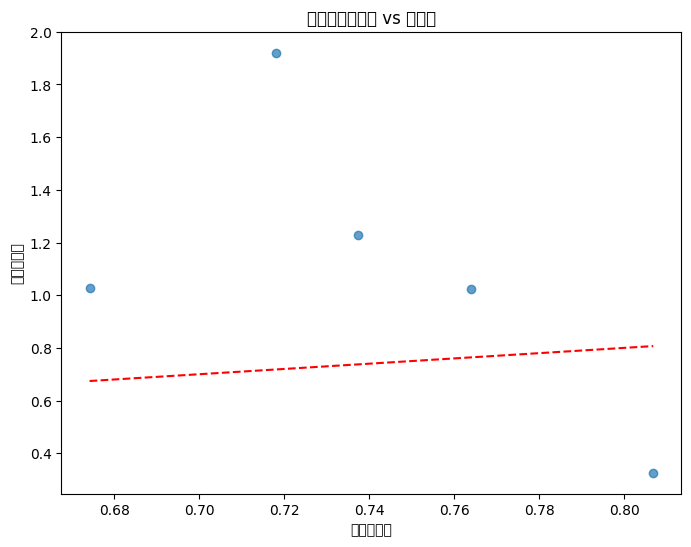

In [32]:
with torch.no_grad():
    predictions = model(data)

    # 损失计算
    test_loss = criterion(predictions[data.test_mask], data.y[data.test_mask])
    print(f'Test Loss: {test_loss.item():.4f}')

    # 转换为numpy数组
    preds = predictions[data.test_mask].numpy().flatten()
    targets = data.y[data.test_mask].numpy().flatten()

    # 计算MSE和R²
    mse = mean_squared_error(targets, preds)
    r2 = r2_score(targets, preds)
    print(f'Test MSE: {mse:.4f}, Test R²: {r2:.4f}')

    # 绘制真实值与预测值对比
    plt.figure(figsize=(8,6))
    plt.scatter(targets, preds, alpha=0.7)
    plt.xlabel('真实协同度')
    plt.ylabel('预测协同度')
    plt.title('测试集：真实值 vs 预测值')
    plt.plot([targets.min(), targets.max()], [targets.min(), targets.max()], 'r--')
    plt.show()

# 可解释性说明

In [36]:
import torch
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"GPU Device Name: {torch.cuda.get_device_name(0)}")

PyTorch Version: 2.5.1+cu121
CUDA Available: False


In [1]:
!pip install torch-geometric==2.3.0 -f https://pytorch-geometric.com/whl/torch-2.0.0+cu118.html

Looking in links: https://pytorch-geometric.com/whl/torch-2.0.0+cu118.html


In [ ]:
# 9. 使用 GNNExplainer 进行节点解释
from torch_geometric.nn import GNNExplainer

# 初始化解释器
explainer = GNNExplainer(model, epochs=200)

# 选择一个节点进行解释
node_idx = 0  # 修改为您感兴趣的节点索引

# 生成解释
node_feat_mask, edge_mask = explainer.explain_node(
    node_idx,
    data.x,
    data.edge_index,
    edge_type=data.edge_type,
    edge_attr=data.edge_attr
)

# 可视化特征重要性
plt.figure(figsize=(10, 6))
plt.bar(feature_columns, node_feat_mask.detach().numpy())
plt.xlabel('特征')
plt.ylabel('重要性权重')
plt.title(f'节点 {node_idx} 的特征重要性')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 可视化重要边
# 首先，构建 NetworkX 图
G = nx.from_edgelist(weights_all[['from_idx', 'to_idx']].values)

# 获取节点位置
pos = nx.spring_layout(G, seed=42)

# 根据边掩码设置边颜色和宽度
edge_colors = ['red' if edge_mask[i] > edge_mask.median() else 'gray' for i in range(len(edge_mask))]
edge_widths = [2 if edge_mask[i] > edge_mask.median() else 0.5 for i in range(len(edge_mask))]

# 设置节点颜色，突出显示目标节点
node_colors = ['skyblue' if i != node_idx else 'orange' for i in range(data.num_nodes)]

plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G, pos, node_size=300, node_color=node_colors)
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths, alpha=0.7)
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title(f'节点 {node_idx} 的重要边网络图')
plt.axis('off')
plt.show()